In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorboard
from keras.callbacks import Callback, TensorBoard
import time
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data = "D:/Research/data/data"
train_dir = data + "/train"
valid_dir = data + "/val"
test_dir = data + "/test"

In [4]:
valid_dir

'D:/Research/data/data/val'

In [5]:
train_datagen = ImageDataGenerator(
    rescale = 1./255
)
valid_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2
)
# data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (224, 224),
    batch_size = 32,
    shuffle = True,
    seed = 64,
    class_mode = "categorical"
)

test_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size = (224, 224),
    batch_size = 32,
    shuffle = False,
    # seed = 64,
    class_mode = "categorical",
    subset = "training"
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size = (224, 224),
    batch_size = 32,
    shuffle = True,
    # seed = 64,
    class_mode = "categorical",
    subset = "validation"
)

Found 1951 images belonging to 4 classes.
Found 260 images belonging to 4 classes.
Found 64 images belonging to 4 classes.


In [6]:
classes = os.listdir(train_dir)
print(classes), print(f" class: {len(classes)}")

['diseased cotton leaf', 'diseased cotton plant', 'fresh cotton leaf', 'fresh cotton plant']
 class: 4


(None, None)

In [19]:
class_count = train_generator.classes
unique, count = np.unique(class_count, return_counts=True)
class_count_dict = dict(zip(train_generator.class_indices, count))
class_count_dict

{'diseased cotton leaf': 288,
 'diseased cotton plant': 815,
 'fresh cotton leaf': 427,
 'fresh cotton plant': 421}

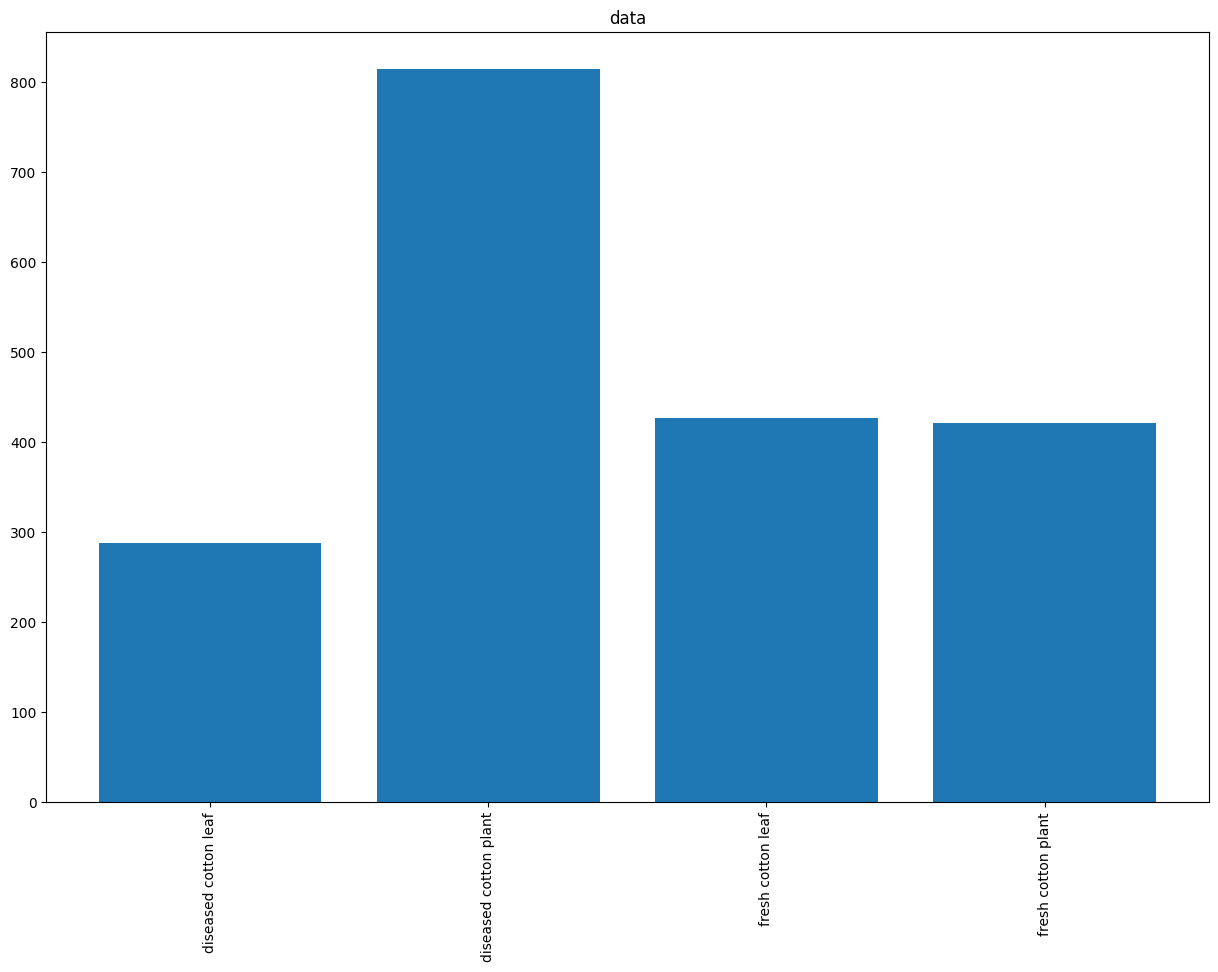

In [20]:
plt.figure(figsize=(15, 10))
plt.bar(class_count_dict.keys(), class_count_dict.values())
plt.xticks(rotation=90)
plt.title("data")
plt.show()

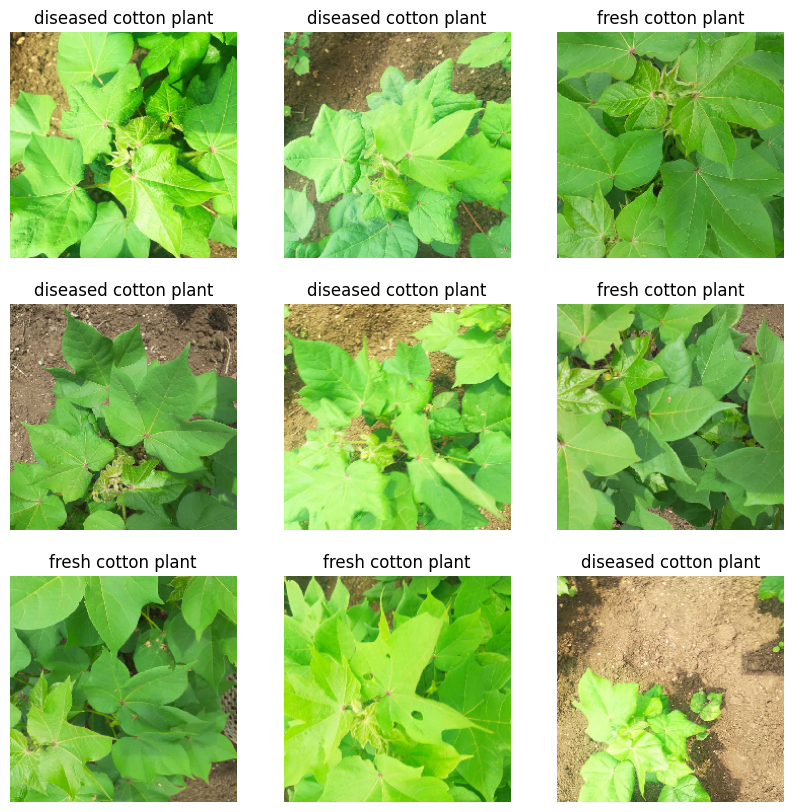

In [21]:
import matplotlib.pyplot as plt

class_map = train_generator.class_indices

inv_class_map = {v: k for k, v in class_map.items()}

img, label = next(train_generator)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(img[i])
    labels = inv_class_map[label[i].argmax()]
    ax.set_title(labels)
    ax.axis("off")
plt.show()


In [22]:
mobileNet = "https://tfhub.dev/google/imagenet/mobilenet_v2_050_224/classification/5"
model = Sequential([
    #layer input
    hub.KerasLayer(mobileNet, input_shape=(224, 224, 3), trainable=False),
    #layer output
    Dense(len(classes), activation="softmax")]
)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [23]:
model.compile(optimizer=Adam(),
              loss=CategoricalCrossentropy(),
              metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              1988505   
                                                                 
 dense (Dense)               (None, 4)                 4008      
                                                                 
Total params: 1,992,513
Trainable params: 4,008
Non-trainable params: 1,988,505
_________________________________________________________________


In [24]:
%load_ext tensorboard

In [25]:
import datetime
def tensorboard_callback(name):
    logdir = os.path.join("Tensorboard/logs",
                          datetime.datetime.now().strftime("%Y%m%d"),f"{name}")
    return TensorBoard(logdir)

In [26]:
class myCallback(Callback):
    def __init__(self, timeout_minute=10, target_accuracy=0.9):
        self.timeout = timeout_minute * 60
        self.accuracy = target_accuracy
    
    def on_train_begin(self, logs={}):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        if logs.get("val_accuracy") is not None and logs.get("val_accuracy") >=  self.accuracy  :
            print(f"\naccuracy has reached {self.accuracy*100}%")
            self.model.stop_training = True
            return
        
        elapsed_time = time.time() - self.start_time
        if elapsed_time > self.timeout:
            print(f"\ntime has reached {self.timeout/60} minutes")
            self.model.stop_training = True

In [27]:
customCallback = myCallback(target_accuracy=0.96)
history = model.fit(train_generator,
                    epochs=100,
                    validation_data=valid_generator,
                    callbacks=[customCallback, tensorboard_callback("2")])

Epoch 1/100
61/61 [==============================] - 42s 604ms/step - loss: 0.6363 - accuracy: 0.7473 - val_loss: 0.3395 - val_accuracy: 0.8281
Epoch 2/100
61/61 [==============================] - 27s 440ms/step - loss: 0.2360 - accuracy: 0.9154 - val_loss: 0.2283 - val_accuracy: 0.9219
Epoch 3/100
61/61 [==============================] - 27s 449ms/step - loss: 0.1746 - accuracy: 0.9477 - val_loss: 0.1924 - val_accuracy: 0.9219
Epoch 4/100
61/61 [==============================] - 27s 443ms/step - loss: 0.1363 - accuracy: 0.9590 - val_loss: 0.1572 - val_accuracy: 0.9531
Epoch 5/100
61/61 [==============================] - 29s 479ms/step - loss: 0.1250 - accuracy: 0.9651 - val_loss: 0.1465 - val_accuracy: 0.9531
Epoch 6/100
61/61 [==============================] - 28s 449ms/step - loss: 0.1078 - accuracy: 0.9718 - val_loss: 0.1392 - val_accuracy: 0.9531
Epoch 7/100
61/61 [==============================] - ETA: 0s - loss: 0.0973 - accuracy: 0.9739
accuracy has reached 96.0%
61/61 [=======

In [28]:
model.save("model_save1")

INFO:tensorflow:Assets written to: model_save1\assets


INFO:tensorflow:Assets written to: model_save1\assets


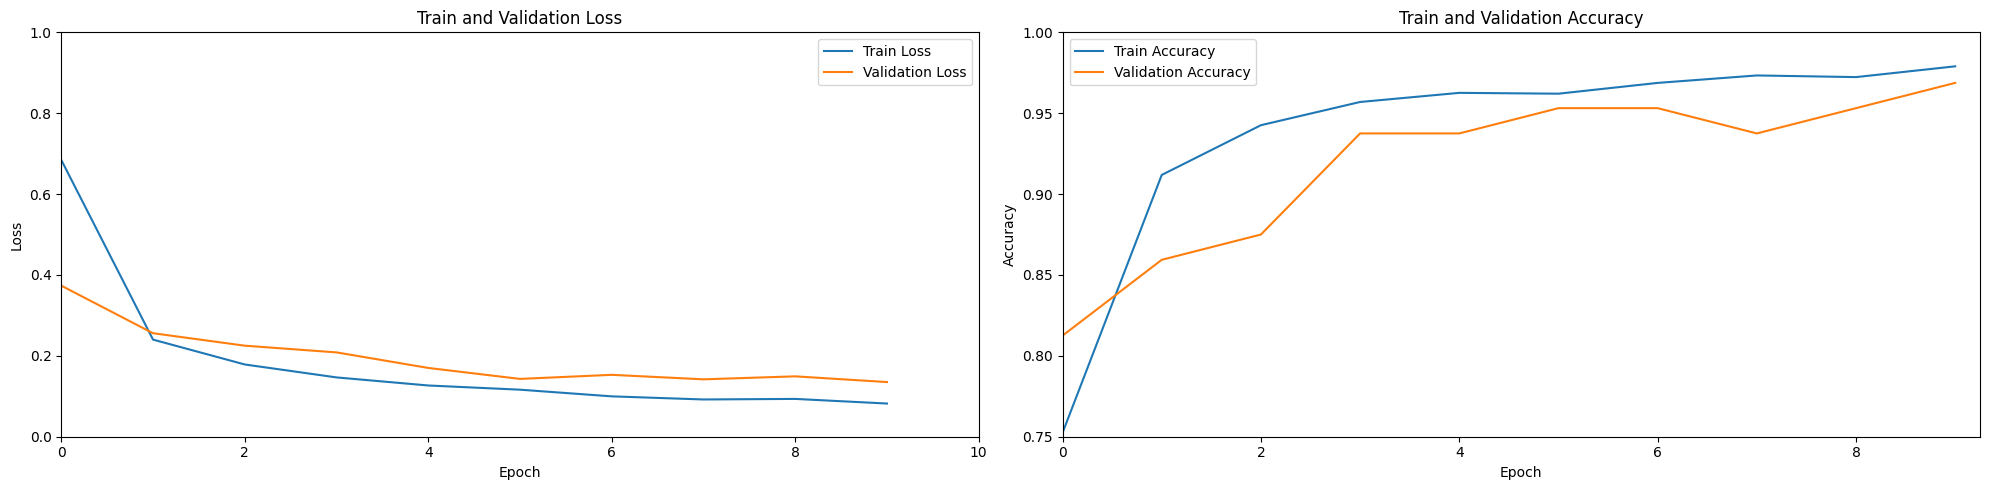

In [17]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['loss'],label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlim(0, 10)
plt.ylim(0.0,1.0)
plt.legend()

plt.subplot(1,2,2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlim(0, 9.25)
plt.ylim(0.75,1.0)
plt.legend()
plt.tight_layout()

1/1 [==============================] - 1s 1s/step


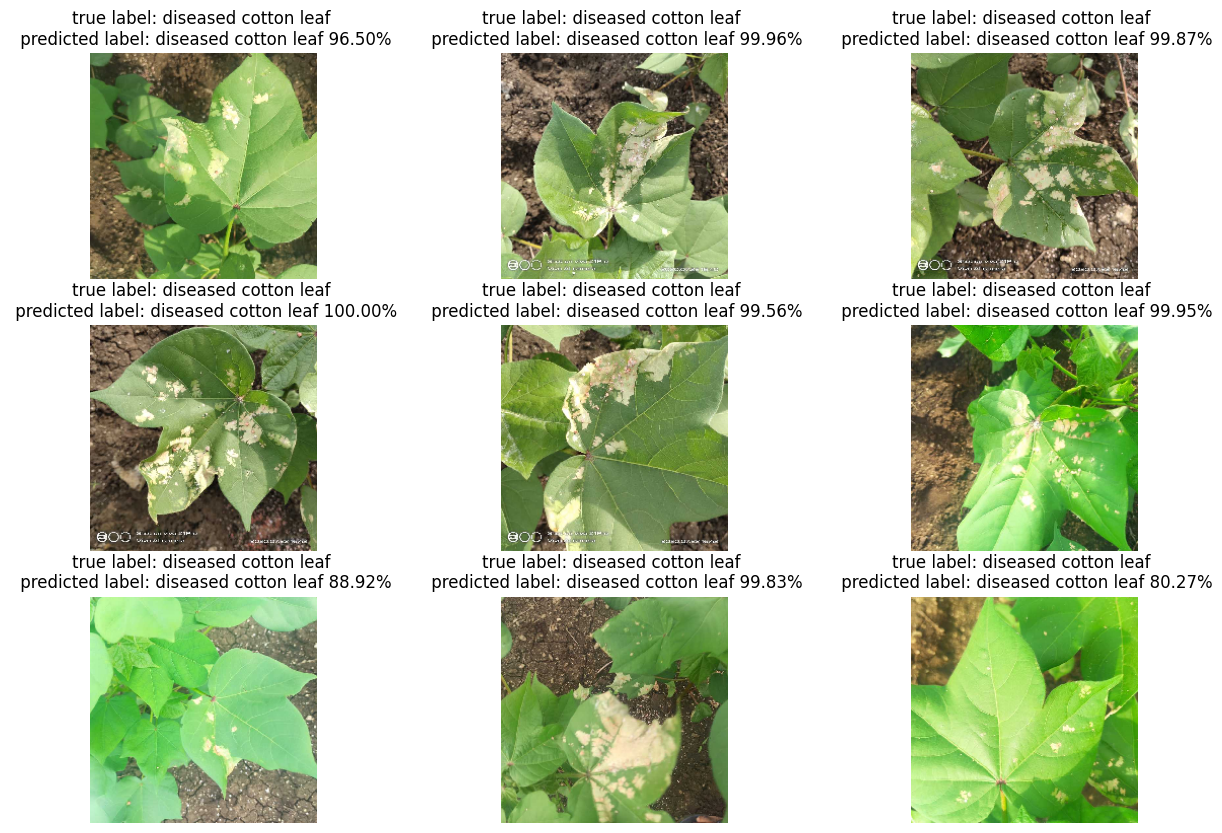

In [29]:
map = test_generator.class_indices
inv_class_indices = {k:v for v,k in map.items()}
img, true_label = next(test_generator)
random_indices = np.random.choice(img.shape[0], 9, replace=False)
images = img[random_indices]
true_labels =true_label[random_indices]

prediction = model.predict(images)

fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(15, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i])
    labels = inv_class_indices[true_labels.argmax()]
    prediction_class = np.argmax(prediction[i])
    prediction_label =inv_class_indices[prediction_class]
    probability_label = prediction[i][prediction_class] * 100
    ax.set_title(f"true label: {labels} \n predicted label: {prediction_label} {probability_label:.2f}%")
    ax.axis("off")